In [1]:
import sys
sys.path.append("../")
import time
from lib.header_script import *
import lib.Common as Common

import lib.DomainDecomposition as DomDec
import lib.DomainDecompositionGPU as DomDecGPU
import lib.DomDecUnbalancedGPU as DomDecUnbalanced
import LogSinkhornGPU
from LogSinkhornGPU import KL, log_dens

import os
import psutil
import time

import torch
import numpy as np
import pickle

from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14
basepath = ""

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
def domdec_serial(pi, offset, cellsize, mu, nu, eps, lam, alphaJ, max_error = 1e-2):
    # Problem data
    slice_prob = slice(offset, -offset, 1) if offset > 0 else slice(None)
    muJ = mu[slice_prob].view(-1, 1, 2*cellsize)
    piJ = pi[slice_prob].view(-1, 2*cellsize, len(nu))
    B = len(muJ)
    x1 = y1 = torch.zeros((B, 1), device = "cuda")
    x2 = torch.arange(len(mu), device = "cuda")[slice_prob].view(-1, 2*cellsize).expand((B, -1)).contiguous()
    y2 = torch.arange(len(nu), device = "cuda").view(1, -1).expand((B, -1)).contiguous()
    
    PYpi = pi.sum(0)
    for i in range(len(piJ)):
        # For serial batches are composed of just one problem
        batch = [i]
        # Serial iter
        muXCell = muJ[batch]
        alphaInit = alphaJ[batch]
        nuJ = piJ[batch].sum(-2).view(len(batch), 1, len(nu))
        C = (x1[batch], x2[batch]), (y1[batch], y2[batch])
        muYref = nu.view(1, 1, -1)
        
        batch_pi, batch_alpha = iter_parallel(muXCell, alphaInit, nuJ, C, muYref, PYpi)
        # Unpack data
        alphaJ[batch] = batch_alpha
        # Update plan and PYpi
        PYpi -= piJ[batch].sum((0,1))
        piJ[batch] = batch_pi
        PYpi += piJ[batch].sum((0,1))
        
    pi_new = torch.zeros_like(pi)
    pi_new[slice_prob] = piJ.view(-1, len(nu))
    return pi_new, alphaJ

def iter_parallel(muXCell, alphaInit, nuJ, C, muYref, PYpi, max_error = 1e-2):
    # Iter function
    muY_nJ = PYpi.view(1, 1, -1) - nuJ
    
    # Solve problem
    solver = LogSinkhornGPU.UnbalancedPartialSinkhornCudaImageOffset(
        muXCell, muYref, C, eps, lam, muY_nJ, alpha_init=alphaInit, nuref=muYref,
        max_error=max_error, max_error_rel=True,
        max_iter=1000, inner_iter=10,
        newton_iter = 10
    )
    solver.iterate_until_max_error()
    
    return solver.get_dense_plan(), solver.alpha

def primal_score(pi, mu, nu, C, lam, eps):
    score = torch.sum(pi*C) + eps*KL(pi, mu.view(-1, 1)*nu.view(1, -1)) + \
            lam*KL(pi.sum(-1), mu) + lam*KL(pi.sum(0), nu)
    return score.item()

def domdec_fast(pi, offset, cellsize, mu, nu, eps, lam, alphaJ, max_error = 1e-2):
    # Problem data
    slice_prob = slice(offset, -offset, 1) if offset > 0 else slice(None)
    muJ = mu[slice_prob].view(-1, 1, 2*cellsize)
    piJ = pi[slice_prob].view(-1, 2*cellsize, len(nu))
    B = len(muJ)
    x1 = y1 = torch.zeros((B, 1), device = "cuda")
    x2 = torch.arange(len(mu), device = "cuda")[slice_prob].view(-1, 2*cellsize).expand((B, -1)).contiguous()
    y2 = torch.arange(len(nu), device = "cuda").view(1, -1).expand((B, -1)).contiguous()
    
    PYpi = pi.sum(0)
    batch = torch.arange(B, device = "cuda")
    # Serial iter
    muXCell = muJ[batch]
    alphaInit = alphaJ[batch]
    nuJ = piJ[batch].sum(-2).view(B, 1, len(nu))
    C = (x1[batch], x2[batch]), (y1[batch], y2[batch])
    muYref = nu.view(1, 1, -1).expand((B, -1, -1))

    piJ, alphaJ = iter_parallel(muXCell, alphaInit, nuJ, C, muYref, PYpi)
        
    pi_new = torch.zeros_like(pi)
    pi_new[slice_prob] = piJ.view(-1, len(nu))
    return pi_new, alphaJ

def domdec_safe(pi, offset, cellsize, mu, nu, eps, lam, alphaJ, max_error = 1e-2):
    pi_fast, alphaJ = domdec_fast(pi, offset, cellsize, mu, nu, eps, lam, alphaJ, max_error = max_error)
    B = (len(mu) - 2*offset) // (2*cellsize)
    pi = (1 - 1/B) * pi + 1/B * pi_fast
    return pi, alphaJ

def domdec_swift(pi, offset, cellsize, mu, nu, eps, lam, alphaJ, max_error = 1e-2):
    pi_fast, alphaJ = domdec_fast(pi, offset, cellsize, mu, nu, eps, lam, alphaJ, max_error = max_error)
    B = (len(mu) - 2*offset) // (2*cellsize)
    pi_safe = (1 - 1/B) * pi + 1/B * pi_fast
    score_fast = primal_score(pi_fast, mu, nu, C_global, lam, eps) 
    score_safe = primal_score(pi_safe, mu, nu, C_global, lam, eps) 
    return (pi_fast if score_fast <= score_safe else pi_safe), alphaJ


def domdec_opt(pi, offset, cellsize, mu, nu, eps, lam, alphaJ, max_error = 1e-2):
    pi_fast, alphaJ = domdec_fast(pi, offset, cellsize, mu, nu, eps, lam, alphaJ, max_error = max_error)
    slice_prob = slice(offset, -offset, 1) if offset > 0 else slice(None)
    muJ = mu[slice_prob].view(-1, 2*cellsize)
    piJ = pi[slice_prob].view(-1, 2*cellsize, len(nu))
    piJ_new = pi_fast[slice_prob].view(-1, 2*cellsize, len(nu))
    CJ = C_global[slice_prob].view(-1, 2*cellsize, len(nu))
    B = len(piJ)
    N_newton = 5
    # Init thetas
    theta = torch.full((B,), 1/B, device = "cuda")
    pi_theta = (1 - theta.view(-1, 1, 1)) * piJ + theta.view(-1, 1, 1)*piJ_new
    muJ += 1e-20
    for i in range(10):
        pi_theta += 1e-20
        pi_theta_dens = pi_theta / (muJ.view(B, -1, 1) * nu.view(1,1,-1))
        piX_theta_dens = torch.exp(log_dens(pi_theta.sum(-1))- log_dens(muJ))
        piY_theta_dens = pi_theta.sum((0,1)) / nu
        diffpiJ = piJ_new - piJ
        diffpiJ_X = diffpiJ.sum(2)
        diffpiJ_Y = diffpiJ.sum(1)
        
        grad_theta = torch.sum(CJ*diffpiJ, (1,2)) + \
                        eps*torch.sum(log_dens(pi_theta_dens)*diffpiJ, (1, 2)) + \
                        lam * torch.sum(log_dens(piX_theta_dens)*diffpiJ_X, 1) + \
                        lam * torch.sum(log_dens(piY_theta_dens).view(1, -1)*diffpiJ_Y,-1)
        # For the hessian first construct crossed terms and then diagonal ones
        
        hessian_theta = lam * (
                diffpiJ_Y.view(B, 1, -1) * diffpiJ_Y.view(1, B, -1) / pi_theta.sum((0,1)).view(1, 1, -1)
            ).sum(-1)
        hessian_theta += torch.diag(
            eps*torch.exp(log_dens(diffpiJ**2)-log_dens(pi_theta)).sum((1, 2)) + \
            lam*(diffpiJ_X**2/pi_theta.sum(-1)).sum(1)
        )
        
        theta -= torch.linalg.solve(hessian_theta, grad_theta)
        theta[theta < 0] = 0.0
        theta[theta > 1] = 1.0
        #print(piX_theta_dens)
        pi_theta = (1 - theta.view(-1, 1, 1)) * piJ + theta.view(-1, 1, 1)*piJ_new
    
    #print(theta)
    pi_opt = torch.zeros_like(pi)
    pi_opt[slice_prob] = pi_theta.view(-1, len(nu))
    return pi_opt, alphaJ

def domdec_staggered(pi, offset, cellsize, mu, nu, eps, lam, alphaJ, max_error = 1e-2):
    # Problem data
    slice_prob = slice(offset, -offset, 1) if offset > 0 else slice(None)
    muJ = mu[slice_prob].view(-1, 1, 2*cellsize)
    piJ = pi[slice_prob].view(-1, 2*cellsize, len(nu))
    B = len(muJ)
    x1 = y1 = torch.zeros((B, 1), device = "cuda")
    x2 = torch.arange(len(mu), device = "cuda")[slice_prob].view(-1, 2*cellsize).expand((B, -1)).contiguous()
    y2 = torch.arange(len(nu), device = "cuda").view(1, -1).expand((B, -1)).contiguous()
    
    PYpi = pi.sum(0)
    # Just one batch for all the problems
    batch_total = torch.arange(B, device = "cuda")
    batch1 = batch_total[::2]
    batch2 = batch_total[1::2]
    for batch in [batch1, batch2]:
        Bi = len(batch)
        muXCell = muJ[batch]
        alphaInit = alphaJ[batch]
        nuJ = piJ[batch].sum(-2).view(Bi, 1, len(nu))
        C = (x1[batch], x2[batch]), (y1[batch], y2[batch])
        muYref = nu.view(1, 1, -1).expand((Bi, -1, -1)).contiguous()

        #print("\n", muXCell.shape, alphaInit.shape, nuJ.shape, x2.shape, y2.shape, muYref.shape, PYpi.shape)
        pi_batch, alpha_batch = iter_parallel(muXCell, alphaInit, nuJ, C, muYref, PYpi)
        piJ_batch = piJ.clone()
        piJ_batch[batch] = pi_batch
        pi_stag = pi.clone()
        pi_stag[slice_prob] = piJ_batch.view(-1, len(nu))
        alphaJ[batch] = alpha_batch
        
        pi_safe = (1 - 1/Bi) * pi + 1/Bi * pi_stag
        score_stag = primal_score(pi_stag, mu, nu, C_global, lam, eps) 
        score_safe = primal_score(pi_safe, mu, nu, C_global, lam, eps) 
        if score_stag <= score_safe: 
            piJ = piJ_batch
        else:
            piJ = (1 - 1/Bi) * piJ + 1/Bi * piJ_batch
        PYpi = piJ.sum((0,1))
        
    
    pi_new = torch.zeros_like(pi)
    pi_new[slice_prob] = piJ.view(-1, len(nu))
    return pi_new, alphaJ
    
        

In [3]:
results_total = dict()

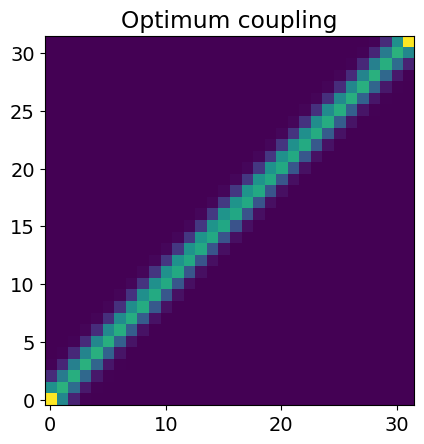

In [7]:
# NOTE: Need to run the script both for N = 32 and N = 64 in order to plot the score decrement plot
N = 32
cellsize = 1
eps = 2.0
reach = 1
lam = (reach*N)**2

mu = torch.ones(2*cellsize + N, device = "cuda") / N
mu[:cellsize] = 0.0
mu[-cellsize:] = 0.0
nu = torch.ones(N, device = "cuda") / N

# Get cost
x = torch.arange(len(mu), device = "cuda")
y = torch.arange(len(nu), device = "cuda")

C_global = (x.view(-1, 1) - y.view(1, -1))**2

# Get solution with sinkhorn
solver_global = LogSinkhornGPU.UnbalancedSinkhornTorch(mu[None, :], nu[None, :], 
                                                       C_global[None, :, :], eps, lam, max_error = 1e-6)
solver_global.iterate_until_max_error()
pi_sinkhorn = solver_global.get_pi_dense().squeeze()
score_sinkhorn = primal_score(pi_sinkhorn,mu, nu, C_global, lam, eps) 

plt.imshow(pi_sinkhorn.cpu()[cellsize:-cellsize].T, origin = "lower")
plt.title("Optimum coupling")
plt.show()
        

In [8]:
# Check different strategies
pi0 = mu.view(-1, 1) * nu.view(1, -1)
# For flipped
#pi0[cellsize:-cellsize] = torch.fliplr(torch.eye(N, device="cuda"))/N
methods = dict(
    sequential = domdec_serial, 
    safe = domdec_safe,
    fast = domdec_fast,
    swift = domdec_swift, 
    opt = domdec_opt, 
    staggered = domdec_staggered
)

Niter = 128

results = dict()
for method_str, method in methods.items():

    # Init alphas
    alphaA = torch.zeros(N // 2*cellsize, 1, 2*cellsize, device = "cuda")
    alphaB = torch.zeros(N // 2*cellsize + 1, 1, 2*cellsize, device = "cuda")


    pi = pi0.clone()
    pi_hist = [pi.clone()]
    time_hist = [0.0]
    for i in tqdm(range(Niter)):
        t0 = time.perf_counter()
        if i%2 == 0:
            # A iter
            offset = cellsize
            pi, alphaA = method(pi, offset, cellsize, mu, nu, eps, lam, 
                                     alphaA, max_error = 1e-3)
        else:
            # B iter
            offset = 0
            pi, alphaB = method(pi, offset, cellsize, mu, nu, eps, lam, 
                                     alphaB, max_error = 1e-3)
        time_hist.append(time.perf_counter() - t0)

        pi_hist.append(pi.clone())
    score_hist = [primal_score(pi,mu, nu, C_global, lam, eps) for pi in pi_hist]
        
    results[method_str] = {"pi_hist" : [pi_.cpu() for pi_ in pi_hist], 
                           "score_hist" : score_hist, "time_hist" : np.cumsum(time_hist)}

results_total[str(N)] = dict(score_sinkhorn = score_sinkhorn, hist = results)


100%|██████████| 128/128 [00:08<00:00, 15.75it/s]


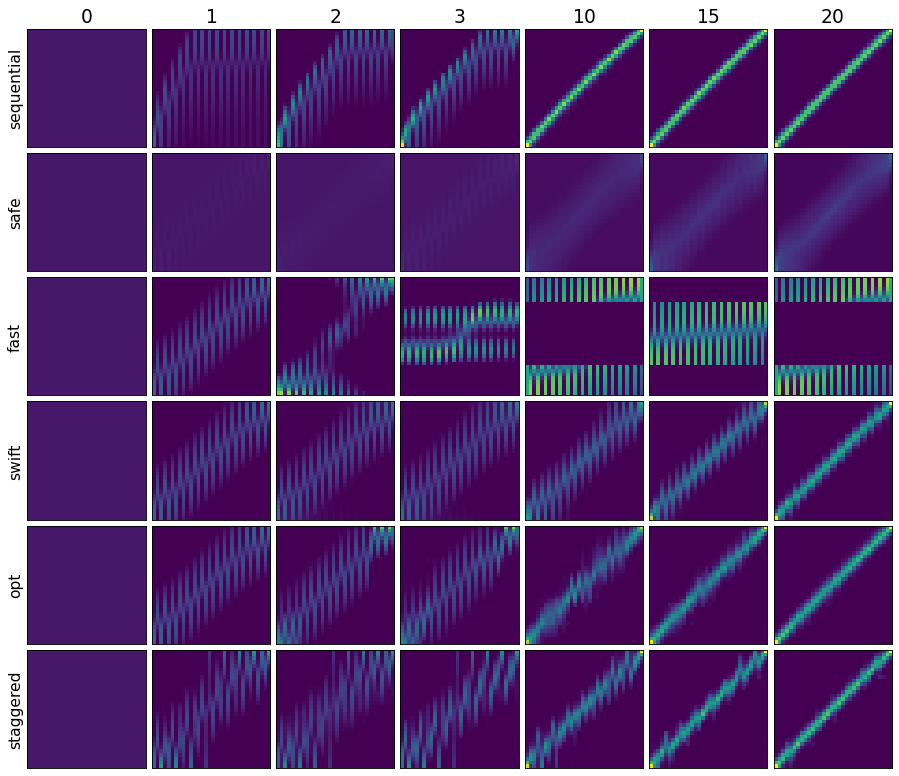

In [9]:
# N = 32, combined
results = results_total["32"]["hist"]
score_sinkhorn = results_total["32"]["score_sinkhorn"]
cellsize = 1

s = 2.0
ks = [0,1,2,3,10,15,20]
nshow = len(ks)
dN = 1
n_method = len(results)
fig, axs = plt.subplots(figsize = (nshow*s,n_method*s), ncols = nshow, nrows = n_method, dpi = 80)
for (i, method_str) in enumerate(results.keys()):
    r = results[method_str]["pi_hist"]
    for j, k in enumerate(ks):
        axs[i,j].imshow(r[k][cellsize:-cellsize].T, origin = "lower", clim = (0, 0.5/32))
        if i == 0:
            axs[i,j].set_title(f"${k}$")
        if j == 0:
            axs[i,j].set_ylabel(method_str)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
# plt.suptitle("Short time behavior", y = 0.92)
plt.subplots_adjust(wspace = 0.02, hspace = 0.05)
plt.savefig(basepath + "strategies-lebesgue-product-joint.pdf", bbox_inches = "tight")
# plt.savefig(basepath + "strategies-lebesgue-product-short.pdf", bbox_inches = "tight")
plt.show()

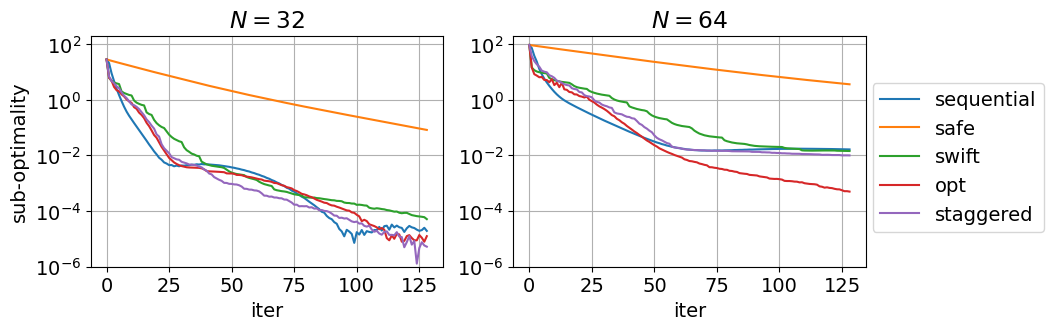

In [10]:
colors = dict(sequential = "tab:blue", safe = "tab:orange", swift = "tab:green",
              opt = "tab:red", staggered = "tab:purple", serial = "tab:blue", stag = "tab:purple")

fig, axs = plt.subplots(1,2, figsize = (10, 3))
axs[1].sharey(axs[0])
for i,N in enumerate([32, 64]):
    ax = axs[i]
    results = results_total[str(N)]["hist"]
    for method_str in results.keys():
        if method_str != "fast":
            try:
                r = results[method_str]
                score_sinkhorn = results_total[str(N)]["score_sinkhorn"]
                score_hist = (np.array(r["score_hist"]) - score_sinkhorn)/score_sinkhorn
                ax.plot(score_hist, label = method_str, color = colors[method_str])
            except KeyError:
                pass
    ax.set_title(f"$N = {N}$")
    ax.set_xlabel("iter")
    if N == 32:
        ax.semilogy()
        ax.set_ylabel("sub-optimality")
        ax.set_ylim([1e-6, 2e2])
    else:
        ax.legend(loc = (1.02, 0.15))
    ax.grid()
plt.subplots_adjust(hspace = 0.3)
plt.savefig(basepath + f"strategies-lebesgue-product-scores.pdf", bbox_inches = "tight")
plt.show()